<h2><center>Introduction</center></h2>

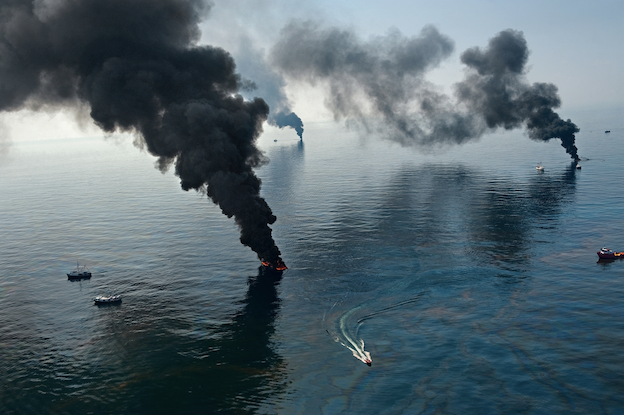

<h3>About the Dataset :</h3>
<div style="font-family:verdana; word-spacing:1.5px;">
In this project, we will use a standard imbalanced machine learning dataset referred to as the oil spill dataset, oil slicks dataset or simply oil. The dataset was introduced in the 1998 paper by Miroslav Kubat, et al. titled Machine Learning for the Detection of Oil Spills in Satellite Radar Images. The dataset is often credited to Robert Holte, a co-author of the paper. The dataset was developed by starting with satellite images of the ocean, some of which contain an oil spill and some that do not. Images were split into sections and processed using computer vision algorithms to provide a vector of features to describe the contents of the image section or patch.
<br><br>
In the task, a model is given a vector that describes the contents of a patch of a satellite image, then predicts whether the patch contains an oil spill or not, e.g. from the illegal or accidental dumping of oil in the ocean. There are 937 cases. Each case is comprised of 48 numerical computer vision derived features, a patch number, and a class label.
<br><br>
    A total of nine satellite images were processed into patches. Cases in the dataset are ordered by image and the first column of the dataset represents the patch number for the image. This was provided for the purposes of estimating model performance per-image. In this case, we are not interested in the image or patch number and this first column can be removed. The normal case is no oil spill assigned the class label of 0, whereas an oil spill is indicated by a class label of 1. There are 896 cases for no oil spill and 41 cases of an oil spill.
</div>

In [ ]:
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import make_scorer
from sklearn.dummy import DummyClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours

from scipy.stats import kurtosis, skew
from scipy import stats

<h3><center>1. Reading Input data</center></h3>

In [ ]:
FILE_PATH = '../input/oil-spill/oil-spill.csv'

oil_df = pd.read_csv(FILE_PATH, header=None)

# Dropping unused columns
oil_df.drop([0,22], axis=1, inplace=True)

In [ ]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

def DataDesc(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

def CalOutliers(df_num): 
    '''
    
    Leonardo Ferreira 20/10/2018
    Set a numerical value and it will calculate the upper, lower and total number of outliers
    It will print a lot of statistics of the numerical feature that you set on input
    
    '''
    # calculating mean and std of the array
    data_mean, data_std = np.mean(df_num), np.std(df_num)

    # seting the cut line to both higher and lower values
    # You can change this value
    cut = data_std * 3

    #Calculating the higher and lower cut values
    lower, upper = data_mean - cut, data_mean + cut

    # creating an array of lower, higher and total outlier values 
    outliers_lower = [x for x in df_num if x < lower]
    outliers_higher = [x for x in df_num if x > upper]
    outliers_total = [x for x in df_num if x < lower or x > upper]

    # array without outlier values
    outliers_removed = [x for x in df_num if x > lower and x < upper]
    
    print(color.BOLD+f'Lower outliers: {len(outliers_lower)}'+ color.END) # printing total number of values in lower cut of outliers
    print(color.BOLD+f'Upper outliers: {len(outliers_higher)}'+ color.END) # printing total number of values in higher cut of outliers
    print(color.BOLD+f'Total outliers: {len(outliers_total)}'+ color.END) # printing total number of values outliers of both sides
    print(color.BOLD+f'Non - outliers: {len(outliers_removed)}'+ color.END) # printing total number of non outlier values
    print(color.BOLD+f'% of Outliers : {round((len(outliers_total) / len(outliers_removed) )*100, 4)}'+ color.END ) # Percentual of outliers in points

<h3><center>2. Exploring Data</center></h3>

In [ ]:
DataDesc(oil_df)

In [ ]:
fig = plt.figure(figsize=(50,50))
ax = fig.gca()

_ = oil_df.hist(ax=ax)

<h3>Target Variable Distribution

In [ ]:
_ = plt.figure(figsize=(8,6))
_ = sns.countplot(oil_df.values[:,-1], palette=['#9fb8ad','#475841'])
_ = plt.xticks([0,1],['Non-Spill','Spill'], fontsize=15)

target = oil_df.values[:,-1]
counter = Counter(target)
for k,v in counter.items():
    per = v / len(target) * 100
    print('Class=%d, Count=%d, Percentage=%.3f%%' % (k, v, per))

<h3><center>3. Model Test & Baseline Result</center></h3>

In [ ]:
def evaluate_model(X, y, model):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    
    metric = make_scorer(geometric_mean_score)
    
    scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
    
    return scores

X, y = oil_df.values[:,:-1], oil_df.values[:,-1]

print(X.shape, y.shape, Counter(y))

model = DummyClassifier(strategy='uniform')

scores = evaluate_model(X, y, model)

print('Mean G-Mean: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))


<blockquote>In this case, we can see that the baseline algorithm achieves a G-mean of about 0.47, close to the theoretical maximum of 0.5. This score provides a lower limit on model skill; any model that achieves an average G-mean above about 0.47 (or really above 0.5) has skill, whereas models that achieve a score below this value do not have skill on this dataset.</blockquote>

<h3><center>4. Evaluate Models </center></h3>

<h3>4.1. Probabilistic models </h3>

In [ ]:
def get_models():
    models, names = list(), list()
    # LR
    steps = [('t',StandardScaler()),('m',LogisticRegression(solver='liblinear'))] 
    models.append(Pipeline(steps=steps))
    names.append('LR')
    
    # LDA
    steps = [('t', StandardScaler()),('m',LinearDiscriminantAnalysis())] 
    models.append(Pipeline(steps=steps))
    names.append('LDA')
    
    # NB
    models.append(GaussianNB())
    names.append('NB')
    
    return models, names


models, names = get_models()

results = list()

for i in range(len(models)):
    scores = evaluate_model(X, y, models[i])
    results.append(scores)
    
    print('>%s %.3f (%.3f)' % (names[i], np.mean(scores), np.std(scores)))

In [ ]:
plt.figure(figsize=(12,6))
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

<h3>4.2. Evaluate balanced Logistic Regression</h3>

In [ ]:
def get_models():
    names, models = list(), list()
    
    #LR balanced
    models.append(LogisticRegression(solver='liblinear', class_weight='balanced'))
    names.append('Balanced')
        
    #LR MinMax
    steps = [('MinMax', MinMaxScaler()),('model',LogisticRegression(solver='liblinear', class_weight='balanced'))]
    models.append(Pipeline(steps=steps))
    names.append('Balanced-MinMax')
    
    #LR StandardScale
    steps = [('StandScale', StandardScaler()),('model',LogisticRegression(solver='liblinear', class_weight='balanced'))]
    models.append(Pipeline(steps=steps))
    names.append('Balanced-Standard')   
    
    #LR Scale + Power Transform
    steps = [('StandScale', MinMaxScaler()),('pt',PowerTransformer()), ('model',LogisticRegression(solver='liblinear', class_weight='balanced'))]
    models.append(Pipeline(steps=steps))
    names.append('Balanced-PowerTransform')
    
    return models, names


models, names = get_models()

results = list()

for i in range(len(models)):
    scores = evaluate_model(X, y, models[i])
    results.append(scores)
    
    print('>%s %.3f (%.3f)' % (names[i], np.mean(scores), np.std(scores)))

In [ ]:
plt.figure(figsize=(12,6))
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

<h3>4.3. Evaluate Damp-Sampling with Probablistic models</h3>

<div style="font-family:verdana; word-spacing:1.5px;">
Data sampling provides a way to better prepare the imbalanced training dataset prior to fitting a model. Perhaps the most popular data sampling is the SMOTE oversampling technique for creating new synthetic examples for the minority class. <br><br>This can be paired with the edited nearest neighbor (ENN) algorithm that will locate and remove examples from the dataset that are ambiguous, making it easier for models to learn to discriminate between the two classes. This combination is called SMOTE-ENN and can be implemented using the SMOTEENN class from the imbalanced-learn library
    </div>

In [ ]:
def get_sampled_data(X, y, name):
    
    sampling = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))
    
    if(name == 'LR'):
        X_s, y_s = sampling.fit_resample(X, y)
        
    elif(name == 'MINMAX'):
        scaler = MinMaxScaler()
        X_scale = scaler.fit_transform(X)
        X_s, y_s = sampling.fit_resample(X_scale, y)
    
    elif(name == 'STDSCALE'):
        scaler = StandardScaler()
        X_scale = scaler.fit_transform(X)
        X_s, y_s = sampling.fit_resample(X_scale, y)
    
    elif(name == 'POWERT'):
        scaler = MinMaxScaler()
        powert = PowerTransformer()
        X_scale = scaler.fit_transform(X)
        X_t = powert.fit_transform(X_scale)
        X_s, y_s = sampling.fit_resample(X_t, y)   
    
    return X_s, y_s


In [ ]:
def evaluate_model(X, y):
    
    model = LogisticRegression(solver='liblinear')
    
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    
    metric = make_scorer(geometric_mean_score)
    
    scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
    
    return scores

In [ ]:
results = list()

for name in ['LR', 'MINMAX', 'STDSCALE', 'POWERT']:
    X_s, y_s = get_sampled_data(X, y, name)
    scores = evaluate_model(X_s, y_s)
    results.append(scores)
    
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))

In [ ]:
names = ['LR', 'MINMAX', 'STDSCALE', 'POWERT']

plt.figure(figsize=(12,6))
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

<h3><center>5. Fitting Model</center></h3>

In [ ]:
from sklearn.model_selection import train_test_split

X_s, y_s = get_sampled_data(X, y, 'POWERT')
X_train, X_test, y_train, y_test = train_test_split(X_s, y_s, test_size=0.1, stratify=y_s, random_state=1)

model = LogisticRegression(solver='lbfgs')

c_values = [10000, 1000, 800, 500, 100, 10, 1.0, 0.1, 0.01, 0.001]
grid = dict(C=c_values)

metric = make_scorer(geometric_mean_score)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)


grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, 
                           scoring=metric,error_score=0)

grid_result = grid_search.fit(X_s, y_s)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

best_model = grid_result.best_estimator_

y_pred = best_model.predict(X_test)

print(confusion_matrix(y_test, y_pred))

print(classification_report(y_test, y_pred))

<h3><center>6. ROC Curve</center></h3>

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
gmeans = np.sqrt(tpr * (1-fpr))

# locate the index of the largest g-mean
ix = np.argmax(gmeans)

print('Best Threshold=%f, G-mean=%.3f' % (thresholds[ix], gmeans[ix]))

In [ ]:
plt.figure(figsize=(10,5))
plt.plot([0,1], [0,1], linestyle='--', label='No Skill') 

plt.plot(fpr, tpr, marker='.', label='Logistic') 
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best') 
# axis labels
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend()
# show the plot
plt.show()

<h3><center>7. Precision Recall Curve</center></h3>

In [ ]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

#Calculate f-Score
fscore = (2 * precision * recall) / (precision + recall)

# locate the index of the largest g-mean
ix = np.argmax(fscore)

print('Best Threshold=%f, F-score=%.3f' % (thresholds[ix], fscore[ix]))

In [ ]:
no_skill = len(y_test[y_test==1]) / len(y_test)

plt.figure(figsize=(10,5))
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill') 
plt.plot(recall, precision, marker='.', label='Logistic') 
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best') 
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

<h3><center>8. Confusion Matrix</center></h3>

In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
cnf_matrix = confusion_matrix(y_test, y_pred)
class_names = ['-VE','+VE']
np.set_printoptions(precision=2)


plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, 
                      title='Normalized confusion matrix')